## A1A Dataset sensitivity c0

In [1]:
import numpy as np
from numpy import linalg as la
from methods import SGD, SGD_decr, SPS_decr
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.datasets import load_svmlight_file

import sys
import math
import seaborn as sns
import random
from tqdm import tqdm
%config InlineBackend.figure_format = 'svg'

markers = ["v","^","<",">","o","s","p","P","*"]
colors = sns.color_palette("colorblind")

### Problem Definition

$$ 
f(x) = \frac{1}{2 n} \sum_{i=1}^n \log (1 + exp(-y_i a_i^T x)) + \frac{\lambda}{2} \|x\|^2_2
$$ 
$$
f_i(x) = \frac{1}{2} \log(1+exp(-y_i a^T_i x)) + \frac{\lambda}{2} \|x\|^2
$$
$$
\nabla f_i(x) = \frac{1}{2} \frac{-y_i}{exp(y_i a_i^T x) + 1} a_i + \lambda x
$$
$$
\nabla^2 f_i(x) = \frac{1}{2} \frac{exp(y_i a_i^T x)y_i^2}{(1+exp(y_i a_i^T x))^2} a_ia_i^T + \lambda 
$$

In [2]:
def get_data():
    data = load_svmlight_file("datasets/a1a.txt")
    return data[0], data[1]

A, y = get_data()

A = A.todense()
A = np.array(A)

n = A.shape[0]
d = A.shape[1]

lambd = 0.01#1/n
mu =  lambd
L = la.norm(A, axis=1, ord=2)**2/8 + lambd

#initialization
np.random.seed(10)
x0=0.1*np.random.randn(d,) #starting position

def cost(x, random_ind):
    batch_size = len(random_ind)
    f = np.sum(np.log(1+np.exp(-np.dot(A[random_ind], x) * y[random_ind])))/(2*batch_size) + (lambd/2)*np.sum(x**2)
    return f

def grad(x, random_ind):
    batch_size = len(random_ind)
    num = -y[random_ind]
    den = (1 + np.exp(np.dot(A[random_ind], x) * y[random_ind]))
    c = num/den
    c2 = np.dot(c.T,A[random_ind])
    final_grad = (c2)/(2*batch_size) + lambd * x
    return final_grad

def hess(x):
    hess_res = lambd*np.identity(d)
    for i in range(n):
        update_hess = (0.5/n) * (y[i]**2) * (np.exp(y[i]*np.dot(A[i],x))) * np.outer(A[i],A[i]) / (1+np.exp(y[i]*np.dot(A[i],x)))**2
        hess_res = hess_res + update_hess
    eigs,_ = la.eig(hess_res)
    return np.min(eigs),np.max(eigs)



f0 = cost(x0, range(n))


### GD solution

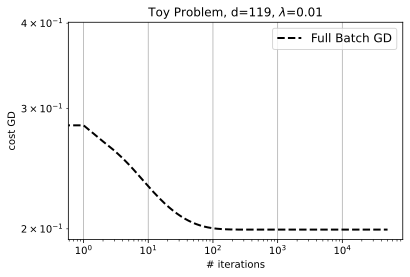

In [3]:
#full batch
batch_size = n
K = 50000 #number of iterations
gamma = 1
_,ff_star,_ = SGD(cost, grad, hess, K, gamma, x0, batch_size, n)
f_sol = ff_star[-1]

#plotting angles
fig, ax = plt.subplots()
plt.xlabel('# iterations')
plt.ylabel('cost GD')
plt.loglog(ff_star,'--',color = 'k',linewidth=2,label = 'Full Batch GD', markevery=2000)
plt.legend(fontsize=12)
plt.title(r"Toy Problem, d="+ str(d)+', $\lambda$={:.2f}'.format(lambd))
ax.grid()

### Running Optimizers

In [4]:
K_record_times = np.power(np.arange(0,45),3)
K=K_record_times[-1]
nexp = 10
compute_hess = True

#running optimizers
methods=[]
f_hist=[]
gammas_hist = []
mu_hist = []
L_hist = []

#sampling batches at the beginning
bs = 20


c = 1
gamma_max = 2
decr = 'sqrt'
name, f, gammas_rec = SPS_decr(cost,grad,hess,nexp, K_record_times, compute_hess, c, decr, gamma_max, x0, bs, n)
methods.append(name)
f_hist.append(f)
gammas_hist.append(gammas_rec)
print('done')


c = 1
gamma_max = 5
decr = 'sqrt'
name, f, gammas_rec = SPS_decr(cost,grad,hess,nexp, K_record_times, compute_hess, c, decr, gamma_max, x0, bs, n)
methods.append(name)
f_hist.append(f)
gammas_hist.append(gammas_rec)
print('done')


c = 1
gamma_max = 10
decr = 'sqrt'
name, f, gammas_rec = SPS_decr(cost,grad,hess,nexp, K_record_times, compute_hess, c, decr, gamma_max, x0, bs, n)
methods.append(name)
f_hist.append(f)
gammas_hist.append(gammas_rec)
print('done')


c = 1
gamma_max = 100
decr = 'sqrt'
name, f, gammas_rec = SPS_decr(cost,grad,hess,nexp, K_record_times, compute_hess, c, decr, gamma_max, x0, bs, n)
methods.append(name)
f_hist.append(f)
gammas_hist.append(gammas_rec)
print('done')


c = 1
gamma_max = 1000
decr = 'sqrt'
name, f, gammas_rec = SPS_decr(cost,grad,hess,nexp, K_record_times, compute_hess, c, decr, gamma_max, x0, bs, n)
methods.append(name)
f_hist.append(f)
gammas_hist.append(gammas_rec)
print('done')


done
done
done
done
done


### Loss

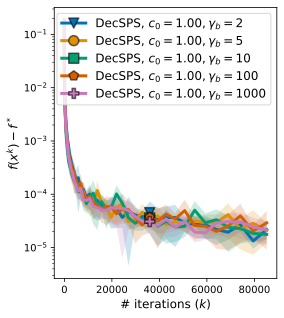

In [8]:
scale = 0.8
fig, ax = plt.subplots(figsize=(4,5))
markers = ["v","o","s","p","P","*"]
colors = sns.color_palette('colorblind')
for i in range(len(methods)):
    mean_f = np.mean(f_hist[i]-f_sol,1)
    std_f = np.std(f_hist[i], 1)
    plt.fill_between(K_record_times,mean_f-scale*std_f,mean_f+scale*std_f , alpha=0.2, fc=colors[i])
    plt.plot(K_record_times,mean_f,color = colors[i],linewidth=3,label = methods[i], markevery=[33], marker = markers[i],markersize = 10,markeredgewidth=1.5, markeredgecolor=[0,0,0,0.6])

plt.yscale("log")
plt.xscale("linear")
#plt.ylim([0.0025,30])
plt.legend(fontsize=12)
plt.xlabel('# iterations $(k)$',fontsize=12)
plt.ylabel('$f(x^k)-f^*$',fontsize=12)
fig.savefig('figures/A1A_SPS_sensitivity_gamma_b',dpi=200, bbox_inches='tight')
